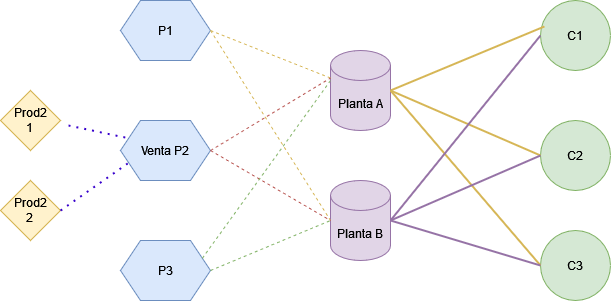

# Formulación

## Conjuntos

* $i \in I=\{P1,P2,P3\}$ productores de te
* $j \in J=\{A,B\}$ plantas de kombucha
* $k \in K=\{C1,C2,C3\}$ Supermercados
* $m \in M = \{Prod2_{1},Prod2_{2}\}$  Almacenaje productor 2

## Parámetros

#### Productores
* $P^{Te}_i$ Costo de compra de un litro de te a productor $i$ [CLP/Litro]
* $d^{Prod}_{i,j}$ Distancia entre el producto de te $i$ y la planta $j$ [km]
* $M^{Prod}_{i}$ Maxima producción de te del productor $i$ [Litro]
* $E^{Prod}_{i}$ Emisiones del productor $i$ [CO2eq/Litro]

#### Plantas
* $C^{Planta}_j$ Costo de producción de un te de kombucha de la planta $j$ [CLP/Litro]
* $M^{Planta}_{j}$ Maxima producción de kombucha de la planta $j$ [Litro]
* $E^{Prod}_{j}$ Emisiones de la planta $j$ [CO2eq/Litro]
* $\eta_{j}$ Eficiencia de producción de kombucha de la planta $j$ [Litro/Litro]
* $d^{Planta}_{j,k}$ Distancia entre el la planta $j$ y el supermercado $k$ [km]

#### Mercados
* $D_k$ Demanda de kombucha del mercado $k$ [Litro]

#### Transporte
* $C^{Transp}$  [CLP/(km Litro)] 
* $E^{Transp}$  [CO2eq/(km Litro)] 

#### Transporte desde tipos de productor 2 a P2

* $C^{TranspP2}_m$   [CLP/(Litro)] 
* $E^{TranspP2}_m$  [CO2eq/(Litro)] 


## Variables

* $F_{i,j} \in \mathbb{R}^{+}$ Litros de te comprados al productor $i$ para la planta $j$.
* $G_{i,j} \in \mathbb{R}^{+}$ Litros de kombucha enviados desde la planta $j$ al supermercado $k$.
* $x_{i} \in \{0,1\}$: Existencia del productor i
* $y_{m} \in \{0,1\}$: Existencia del almacenaje de productor 2 m
* $P_{m} \in \mathbb{R}^{+}$: Litros de kombucha enviados desde el almacenaje de productor 2 m al productor 2 

## Restricciones normales

* No se puede sobrepasar la capacidad de ningún productor de te
$$\sum_{j\in J}F_{i,j}\leq M^{Prod}_{i} \quad \forall i \in I$$

* No se puede sobrepasar la capacidad de producción de ninguna planta
$$\sum_{k\in K}G_{j,k}\leq M^{Planta}_{j} \quad \forall j \in J$$

* Cada planta tiene una eficiencia de producción de kombucha
$$\sum_{i\in I}F_{i,j} \cdot \eta_{j}^{Planta} = \sum_{k\in K}G_{j,k}\quad \forall j \in J$$

* Se debe cumplir la demanda de cada supermercado
$$\sum_{j\in J}G_{j,k} \geq D_{k} \quad \forall k \in K$$

* Balance del productor 2 

$$\sum_{j\in J}F_{2,j} = \sum_{m\in M}P_{m} $$



## Restricciones de lógica

* Existencia de productor 2 y la existencia de los tipos de productor 2

$$1-x_2 + y_1 + y_2 \geq 1$$ 

$$1-y_1+x_2 \geq 1$$ 

$$1-y_2+x_2 \geq 1$$

* Existencia de al menos un productor 

$$\sum_{i \in I}x_i \geq 1$$

* Coherencia entre flujos de un productor y su existencia

$$M*x_i \geq \sum_{j \in J}F_{i,j} \quad \forall i \in I$$





## Funciones objetivo
* Minimizar el costo total del sistema
$$\text{Min: } \sum_{i,j}P^{Te}_{i}\cdot F_{i,j} + \sum_{i,j}C^{Transp}\cdot F_{i,j} + \sum_{j,k}C^{Planta}_j\cdot G_{j,k} +  \sum_{j,k}C^{Transp}\cdot G_{j,k} + \sum_{m \in M}C^{Transp}_m \cdot P_m$$  

* Minimizar las emisiones totales del sistema
$$\text{Min: } \sum_{i,j}E^{Prod}_{i}\cdot F_{i,j} + \sum_{i,j}E^{Transp}\cdot F_{i,j} + \sum_{j,k}E^{Planta}_j\cdot G_{j,k} +  \sum_{j,k}E^{Transp}\cdot G_{j,k} + \sum_{m \in M}E^{Transp}_m \cdot P_m$$ $$


In [1]:
#Uso de modulos
using Cbc
using JuMP
using DataFrames

In [2]:
###Conjuntos###

#Productores de te
I = ["P1","P2", "P3"]

#Plantas
J = ["A","B"]

#Supermercados
K = ["C1","C2", "C3"]

#Almacenaje

M = ["P2_1","P2_2"]

###Parámetros###
##Productores##

#Precio de compra de te
P_Te = Dict{String, Real}()
P_Te["P1"] = 200
P_Te["P2"] = 225
P_Te["P3"] = 250

#Distancia entre productores de te y plantas 
d_Prod = Dict{Tuple{String,String}, Real}()

d_Prod["P1","A"] = 15
d_Prod["P1","B"] = 10

d_Prod["P2","A"] = 7
d_Prod["P2","B"] = 6

d_Prod["P3","A"] = 12
d_Prod["P3","B"] = 20

#Maxima producción de te
M_Te = Dict{String,Real}()
M_Te["P1"] = 2000
M_Te["P2"] = 1500
M_Te["P3"] = 1700

#Emisiones por producción
E_Te = Dict{String,Real}()
E_Te["P1"] = 20
E_Te["P2"] = 50
E_Te["P3"] = 15

##Plantas##

#Costo de producción de kombucha
C_kombucha = Dict{String,Real}()
C_kombucha["A"] = 150
C_kombucha["B"] = 210

#Maxima producción de kombucha
M_kombucha = Dict{String,Real}()
M_kombucha["A"] = 2100
M_kombucha["B"] = 2000

#Emisiones por producción
E_kombucha = Dict{String,Real}()
E_kombucha["A"] = 120
E_kombucha["B"] = 80

#Eficiencia de producción
eta = Dict{String,Real}()
eta["A"] = 0.72
eta["B"] = 0.85

#Distancia entre plantas y mercados
d_Planta = Dict{Tuple{String,String}, Real}()

d_Planta["A","C1"] = 40
d_Planta["A","C2"] = 50
d_Planta["A","C3"] = 25

d_Planta["B","C1"] = 50
d_Planta["B","C2"] = 30
d_Planta["B","C3"] = 32

##Demanda##
D = Dict{String,Real}()
D["C1"] = 1000
D["C2"] = 820
D["C3"] = 1100

##Transporte##
#Costo de transporte
C_Transp = 0.1

#Costo del transporte por flujo desde m a P2

C_Transp_P2 = Dict()

C_Transp_P2["P2_1"] = 0.001
C_Transp_P2["P2_2"] = 0.004

#Emision de transporte
E_Transp = 0.07

#Emisiones del transporte por flujo desde m a p2

E_Transp_P2 = Dict()

E_Transp_P2["P2_1"] = 0.0015
E_Transp_P2["P2_2"] = 0.006

#BIG M

BigM = 20000
;

In [3]:
#Modelo
p1 = Model(Cbc.Optimizer)

#--------------
#Variables
#--------------

#Litros de te comprados
@variable(p1, F[i in I, j in J] >= 0)

#Litros de kombucha enviados
@variable(p1, G[j in J, k in K] >= 0)

#Existencia de productor i
@variable(p1, x[i in I], Bin)

#Existencia de almacenaje de productor 2
@variable(p1, y[m in M], Bin)

#Flujo de tipo de productor 2 a P2

@variable(p1, P[m in M] >= 0)

#--------------
#Restricciones
#--------------

#No sobrepasar capacidades productivas de te
for i in I
    @constraint(p1, sum(F[i,j] for j in J) <= M_Te[i])
end

#No sobrepasar capacidades productivas de plantas
for j in J
    @constraint(p1, sum(G[j,k] for k in K) <= M_kombucha[j])
end

#Producción de kombucha
for j in J
    @constraint(p1, sum(G[j,k] for k in K) == eta[j]*sum(F[i,j] for i in I))
end

#Cumplimiento de demanda
for k in K
   @constraint(p1, sum(G[j,k] for j in J) >= D[k])
end 

#Flujos de tipo de productor 2 a P2

@constraint(p1, sum(F["P2",j] for j in J) == sum(P[m] for m in M))

#Lógica

@constraint(p1, 1-x["P2"]+y["P2_1"]+y["P2_2"] >= 1)

@constraint(p1, 1-y["P2_1"]+x["P2"] >= 1)

@constraint(p1, 1-y["P2_2"]+x["P2"] >= 1)

@constraint(p1, sum(x[i] for i in I) >= 1)

#Big M

for i in I
    @constraint(p1, BigM*x[i] >= sum(F[i,j] for j in J))
end

#--------------
#F.O
#--------------

#Anotamos la expresión de la función de emisión:

@expression(p1, emisiones, sum(E_Te[i]*F[i,j] for i in I for j in J) + sum(E_Transp*F[i,j] for i in I for j in J) + sum(E_kombucha[j]*G[j,k] for j in J for k in K) + sum(E_Transp*G[j,k] for j in J for k in K)+sum(E_Transp_P2[m]*P[m] for m in M))
@expression(p1, costos, sum(P_Te[i]*F[i,j] for i in I for j in J) + sum(C_Transp*F[i,j] for i in I for j in J) + sum(C_kombucha[j]*G[j,k] for j in J for k in K) + sum(C_Transp*G[j,k] for j in J for k in K)+sum(C_Transp_P2[m]*P[m] for m in M))

#Minimizar los costos 
@objective(p1, Min, costos)
optimize!(p1)#resuelve el modelo m!


Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 1.32072e+06 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 14 rows, 15 columns (3 integer (3 of which binary)) and 41 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.32072e+06
Cbc0038I Relaxing continuous gives 1.32072e+06
Cbc0038I Before mini branch and bound, 3 integers at bound fixed and 5 continuous
Cbc0038I Mini branch and bound did not improve solution (0.10 seconds)
Cbc0038I After 0.10 seconds - Feasibility pump exiting with objective of 1.32072e+06 - took 0.00 seconds
Cbc0012I Integer solution of 1320724.8 found by feasibility pump after 0 iterations and 0 nodes (0.13 seconds)
Cbc0001I Search completed - best objective 1320724.774509804, took 0 iterations and 0 nodes (0.13 seconds)
Cbc0035I Maxi

In [4]:
#------------------------------------------------------------------------------
#Resultados
#------------------------------------------------------------------------------

#Leche
df_Leche = DataFrame(Productor=[], Planta=[], Compra=[])
for i in I
    for j in J
        Lechero = i
        Planta = j
        Compra = JuMP.value(F[i,j])
        if Compra > 0
            push!(df_Leche,hcat(Lechero,Planta,Compra))
        end
    end
end

#Yoghurt
df_Yoghurt = DataFrame(Planta=[], Mercado=[], Compra=[])
for j in J
    for k in K
        Planta = j
        Mercado = k
        Compra = JuMP.value(G[j,k])
        if Compra > 0
            push!(df_Yoghurt,hcat(Planta,Mercado,Compra))
        end
    end
end

println("La compra a productores de te en el modelo económico corresponde a:")
show(df_Leche, allrows=true, allcols=true)
    
println("")
println("La venta a mercados en el modelo económico corresponde a:")
show(df_Yoghurt, allrows=true, allcols=true)

println("")
println("El valor ideal de costos es: ", value.(costos))
println("El valor anti-ideal de emisiones es: ", value.(emisiones))

costos_id = value.(costos);
emisiones_anid= value.(emisiones);

La compra a productores de te en el modelo económico corresponde a:
4×3 DataFrame
 Row │ Productor  Planta  Compra  
     │ Any        Any     Any     
─────┼────────────────────────────
   1 │ P1         A       2000.0
   2 │ P2         A       535.294
   3 │ P2         B       964.706
   4 │ P3         A       381.373
La venta a mercados en el modelo económico corresponde a:
4×3 DataFrame
 Row │ Planta  Mercado  Compra 
     │ Any     Any      Any    
─────┼─────────────────────────
   1 │ A       C1       1000.0
   2 │ A       C2       820.0
   3 │ A       C3       280.0
   4 │ B       C3       820.0
El valor ideal de costos es: 1.3207247745098039e6
El valor anti-ideal de emisiones es: 438798.93431372545


In [5]:
#--------------
#F.O
#--------------

#Minimizar las emisiones
@objective(p1, Min, emisiones)
optimize!(p1)#resuelve el modelo m!

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 334973 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 14 rows, 15 columns (3 integer (3 of which binary)) and 41 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 334973
Cbc0038I Relaxing continuous gives 334973
Cbc0038I Before mini branch and bound, 3 integers at bound fixed and 5 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds - Feasibility pump exiting with objective of 334973 - took 0.00 seconds
Cbc0012I Integer solution of 334972.93 found by feasibility pump after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 334972.9294117647, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 varia

In [6]:
#------------------------------------------------------------------------------
#Resultados
#------------------------------------------------------------------------------

#Leche
df_Leche_E = DataFrame(Productor=[], Planta=[], Compra=[])
for i in I
    for j in J
        Lechero = i
        Planta = j
        Compra = JuMP.value(F[i,j])
        if Compra > 0
            push!(df_Leche_E,hcat(Lechero,Planta,Compra))
        end
    end
end

#Yoghurt
df_Yoghurt_E = DataFrame(Productor=[], Mercado=[], Compra=[])
for j in J
    for k in K
        Planta = j
        Mercado = k
        Compra = JuMP.value(G[j,k])
        if Compra > 0
            push!(df_Yoghurt_E,hcat(Planta,Mercado,Compra))
        end
    end
end

println("La compra a productores de te en el modelo ambiental corresponde a:")
show(df_Leche_E, allrows=true, allcols=true)
    
println("")
println("La venta a mercados en el modelo ambiental corresponde a:")
show(df_Yoghurt_E, allrows=true, allcols=true)
        
println("")
println("El valor ideal de emisiones es: ", value.(emisiones))
println("El valor anti-ideal de costos es: ", value.(costos))

emisiones_id = value.(emisiones);
costos_anid = value.(costos);

La compra a productores de te en el modelo ambiental corresponde a:
3×3 DataFrame
 Row │ Productor  Planta  Compra  
     │ Any        Any     Any     
─────┼────────────────────────────
   1 │ P1         B       1930.72
   2 │ P3         A       1277.78
   3 │ P3         B       422.222
La venta a mercados en el modelo ambiental corresponde a:
4×3 DataFrame
 Row │ Productor  Mercado  Compra 
     │ Any        Any      Any    
─────┼────────────────────────────
   1 │ A          C3       920.0
   2 │ B          C1       1000.0
   3 │ B          C2       820.0
   4 │ B          C3       180.0
El valor ideal de emisiones es: 334972.9294117647
El valor anti-ideal de costos es: 1.369798862745098e6


# b) Sumas ponderadas

El problema consiste en optimizar la siguiente función objetivo

$$ \sum_{i\ in I}w_i*f_i$$ 

Donde $w_i \in \[0,1\]$ representa el peso, i.e, la importancia que tiene cada función objetivo dentro de lo que nosotres consideremos pertinente dado el problema que estamos resolviendo, pero existe un problema, podemos realmente sumar costos y emisiones por ejemplo, cuando tienen valores númericos que pueden ser de distinta dimensión, por ejemplo, si los costos son del orden de los 100 millones de pesos y las emisiones del orden de 100 mil $kgCO_2-eq$, númericamente tenemos un problema, siempre va a considerar más importante los costos dado que el valor númerico es mucho mayor, para ello entonces, normalizamos las funciones objetivos!:


$$ \overline{f_i} = \frac{FO_{i,ideal}-FO_{i}}{FO_{i,anti-ideal}-FO_{i,ideal}}$$

Para nuestro caso se tiene 

$$ \overline{FO_{emisiones}} = \frac{FO_{emisiones,ideal}-FO_{emisiones}}{FO_{emisiones,anti-ideal}-FO_{emisiones,ideal}} $$

$$\overline{FO_{costos}} = \frac{FO_{costos,ideal}-FO_{costos}}{FO_{costos,anti-ideal}-FO_{costos,ideal}}$$

Luego nuestra función objetivo queda: 


$$Min ~~ w\cdot \overline{FO_{emisiones}} + (1-w)\cdot \overline{FO_{costos}}$$

Dado que es preciso notar que como solo tenemos un $w_i$ y un $w_j$, podemos escribir el otro en función del primero como $1-w_i$

Ahora con un ciclo for resolvemos para cada peso y encontramos nuestra curva de pareto! 


In [7]:
w = collect(0:0.1:1);
vector_costos = []
vector_emisiones = []

for i in w
    @objective(p1, Min, i*(emisiones_id-emisiones)/(emisiones_id-emisiones_anid) + (1-i)*(costos_id-costos)/(costos_id-costos_anid))
    optimize!(p1)
    vector_costos=[vector_costos; value.(costos)]
    vector_emisiones=[vector_emisiones; value.(emisiones)]
end

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 26.9129 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 14 rows, 15 columns (3 integer (3 of which binary)) and 41 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 26.9129
Cbc0038I Relaxing continuous gives 26.9129
Cbc0038I Before mini branch and bound, 3 integers at bound fixed and 5 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds - Feasibility pump exiting with objective of 26.9129 - took 0.00 seconds
Cbc0012I Integer solution of 26.912874 found by feasibility pump after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 26.91287443135694, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 v

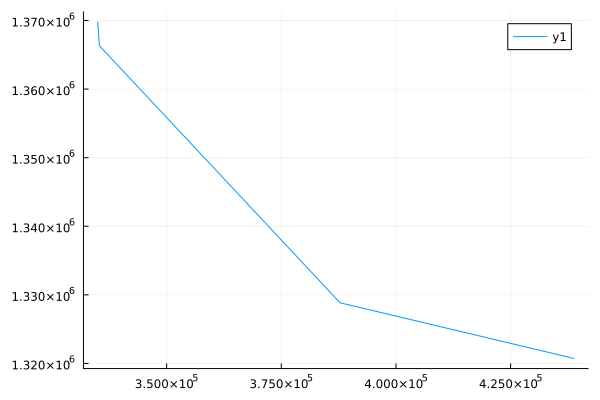

In [8]:
using Plots
plot(vector_emisiones, vector_costos)

# c) Programación por metas: 

Consiste en el siguiente problema de minimización 

$$ Min ~~ \gamma \\
s.a ~~ \overline{f_i} \leq w\cdot \gamma \\
    \overline{f_j} \leq (1-w)\cdot \gamma$$
    
Donde $\gamma$ representa la distancia del punto ideal a la curva de pareto, entonces uno busca minimizar la distancia del punto ideal a la curva de pareto, mediante las siguientes restricciones

$$\frac{FO_{emisiones,ideal}-FO_{emisiones}}{FO_{emisiones,anti-ideal}-FO_{emisiones,ideal}} \leq w*\gamma$$

$$\frac{FO_{costos,ideal}-FO_{costos}}{FO_{costos,anti-ideal}-FO_{costos,ideal}} \leq (1-w)*\gamma$$


In [9]:
w=0.5

#Modelo Programación por metas
p2 = Model(Cbc.Optimizer)

#--------------
#Variables
#--------------

#Litros de te comprados
@variable(p2, F[i in I, j in J] >= 0)

#Litros de kombucha enviados
@variable(p2, G[j in J, k in K] >= 0)

#Existencia de productor i
@variable(p2, x[i in I], Bin)

#Existencia de tipo de productor 2
@variable(p2, y[m in M], Bin)

#Flujo de tipo de productor 2 a P2

@variable(p2, P[m in M] >= 0)

#Programación por metas
@variable(p2, alfa)

@variable(p2, costos>=0)

@variable(p2, emisiones>=0)


#--------------
#Restricciones
#--------------

#No sobrepasar capacidades productivas de te
for i in I
    @constraint(p2, sum(F[i,j] for j in J) <= M_Te[i])
end

#No sobrepasar capacidades productivas de plantas
for j in J
    @constraint(p2, sum(G[j,k] for k in K) <= M_kombucha[j])
end

#Producción de kombucha
for j in J
    @constraint(p2, sum(G[j,k] for k in K) == eta[j]*sum(F[i,j] for i in I))
end

#Cumplimiento de demanda
for k in K
   @constraint(p2, sum(G[j,k] for j in J) >= D[k])
end 

#Flujos de tipo de productor 2 a P2

@constraint(p2, sum(F["P2",j] for j in J) == sum(P[m] for m in M))

#Lógica

@constraint(p2, 1-x["P2"]+y["P2_1"]+y["P2_2"] >= 1)

@constraint(p2, 1-y["P2_1"]+x["P2"] >= 1)

@constraint(p2, 1-y["P2_2"]+x["P2"] >= 1)

@constraint(p2, sum(x[i] for i in I) >= 1)

#Big M

for i in I
    @constraint(p2, BigM*x[i] >= sum(F[i,j] for j in J))
end
#Programación por metas 

@constraint(p2, emisiones == sum(E_Te[i]*F[i,j] for i in I for j in J) + sum(E_Transp*F[i,j] for i in I for j in J) + sum(E_kombucha[j]*G[j,k] for j in J for k in K) + sum(E_Transp*G[j,k] for j in J for k in K)+sum(E_Transp_P2[m]*P[m] for m in M))
@constraint(p2, costos == sum(P_Te[i]*F[i,j] for i in I for j in J) + sum(C_Transp*F[i,j] for i in I for j in J) + sum(C_kombucha[j]*G[j,k] for j in J for k in K) + sum(C_Transp*G[j,k] for j in J for k in K)+sum(C_Transp_P2[m]*P[m] for m in M))
@constraint(p2, (emisiones_id-emisiones)/(emisiones_id-emisiones_anid) <= w*alfa)
@constraint(p2, (costos_id-costos)/(costos_id-costos_anid) <= (1-w)*alfa)

@objective(p2, Min, alfa)
optimize!(p2)



Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 0.744262 - 0.03 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 17 rows, 18 columns (3 integer (3 of which binary)) and 75 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.541379
Cbc0038I Solution found of 0.744262
Cbc0038I Relaxing continuous gives 0.744262
Cbc0038I Before mini branch and bound, 1 integers at bound fixed and 5 continuous
Cbc0038I Mini branch and bound did not improve solution (0.04 seconds)
Cbc0038I After 0.04 seconds - Feasibility pump exiting with objective of 0.744262 - took 0.00 seconds
Cbc0012I Integer solution of 0.74426163 found by feasibility pump after 0 iterations and 0 nodes (0.04 seconds)
Cbc0001I Search completed - best objective 0.7442616254096174, took 0 iterations and 0 nodes (0.04 seconds)
Cbc0035I Maximum

In [13]:
value.(emisiones) 

366120.7308823529

In [14]:
value.(costos)

1.3443356360035783e6

# d) $\epsilon$-constraint

El modelo consiste en minimizar para una de las funciones objetivos agregando la siguiente restricción:

$$\overline{f_i} \leq \epsilon$$

En este caso nuestra función normalizada a acotar es la de emisiones

$$\frac{FO_{emisiones,ideal}-FO_{emisiones}}{FO_{emisiones,anti-ideal}-FO_{emisiones,ideal}} \leq \epsilon$$ 

Con $\epsilon = 0.3$

In [10]:
e=0.3

#Modelo e-constraint
p3 = Model(Cbc.Optimizer)

#--------------
#Variables
#--------------

#Litros de te comprados
@variable(p3, F[i in I, j in J] >= 0)

#Litros de kombucha enviados
@variable(p3, G[j in J, k in K] >= 0)

#Existencia de productor i
@variable(p3, x[i in I], Bin)

#Existencia de tipo de productor 2
@variable(p3, y[m in M], Bin)

#Flujo de tipo de productor 2 a P2

@variable(p3, P[m in M] >= 0)


#--------------
#Restricciones
#--------------

#No sobrepasar capacidades productivas de te
for i in I
    @constraint(p3, sum(F[i,j] for j in J) <= M_Te[i])
end

#No sobrepasar capacidades productivas de plantas
for j in J
    @constraint(p3, sum(G[j,k] for k in K) <= M_kombucha[j])
end

#Producción de kombucha
for j in J
    @constraint(p3, sum(G[j,k] for k in K) == eta[j]*sum(F[i,j] for i in I))
end

#Cumplimiento de demanda
for k in K
   @constraint(p3, sum(G[j,k] for j in J) >= D[k])
end 

#Flujos de tipo de productor 2 a P2

@constraint(p3, sum(F["P2",j] for j in J) == sum(P[m] for m in M))

#Lógica

@constraint(p3, 1-x["P2"]+y["P2_1"]+y["P2_2"] >= 1)

@constraint(p3, 1-y["P2_1"]+x["P2"] >= 1)

@constraint(p3, 1-y["P2_2"]+x["P2"] >= 1)

@constraint(p3, sum(x[i] for i in I) >= 1)

#Big M

for i in I
    @constraint(p3, BigM*x[i] >= sum(F[i,j] for j in J))
end

@expression(p3, emisiones, sum(E_Te[i]*F[i,j] for i in I for j in J) + sum(E_Transp*F[i,j] for i in I for j in J) + sum(E_kombucha[j]*G[j,k] for j in J for k in K) + sum(E_Transp*G[j,k] for j in J for k in K)+sum(E_Transp_P2[m]*P[m] for m in M))
@expression(p3, costos, sum(P_Te[i]*F[i,j] for i in I for j in J) + sum(C_Transp*F[i,j] for i in I for j in J) + sum(C_kombucha[j]*G[j,k] for j in J for k in K) + sum(C_Transp*G[j,k] for j in J for k in K)+sum(C_Transp_P2[m]*P[m] for m in M))

#e-constraint
@constraint(p3, (emisiones_id-emisiones)/(emisiones_id-emisiones_anid) <= e)

@objective(p3, Min, costos)
optimize!(p3)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 1.34434e+06 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 16 rows, 17 columns (3 integer (3 of which binary)) and 59 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.826664
Cbc0038I Solution found of 1.34434e+06
Cbc0038I Relaxing continuous gives 1.34434e+06
Cbc0038I Before mini branch and bound, 1 integers at bound fixed and 6 continuous
Cbc0038I Mini branch and bound did not improve solution (0.01 seconds)
Cbc0038I After 0.01 seconds - Feasibility pump exiting with objective of 1.34434e+06 - took 0.00 seconds
Cbc0012I Integer solution of 1344335.6 found by feasibility pump after 0 iterations and 0 nodes (0.01 seconds)
Cbc0001I Search completed - best objective 1344335.636003578, took 0 iterations and 0 nodes (0.01 seconds)
Cbc003